In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', 500); pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm; plt.rcParams['figure.figsize'] = (12, 6); plt.style.use('seaborn')
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from tqdm.notebook import tqdm; tqdm.pandas()
import os
import datetime
import pickle
from sys import getsizeof

from joblib import dump, load

## Leer data

In [2]:
if os.path.exists('items_df.df'):
    items_df = pd.read_pickle('items_df.df')
else:
    items_df = pd.read_json('item_data.jl', lines=True, dtype={'product_id': object}).set_index('item_id')
    items_df.to_pickle('items_df.df')

if os.path.exists('train_df.df'):
    train_df = pd.read_pickle('train_df.df')
else:
    train_df = pd.read_json('train_dataset.jl', lines=True)
    train_df.to_pickle('train_df.df')

if os.path.exists('test_df.df'):
    test_df = pd.read_pickle('test_df.df')
else:
    test_df = pd.read_json('test_dataset.jl', lines=True)
    test_df.to_pickle('test_df.df')

if os.path.exists('train_target.series'):
    train_target = pd.read_pickle('train_target.series')
else:
    raise Exception('El archivo train_target.series no se encontró.')

In [3]:
for df in [items_df, train_df, test_df, train_target]:
    display(df.head(2), df.shape)
    print('Tamaño en RAM en MBs:', getsizeof(df)/1000000)

,title,domain_id,product_id,price,category_id,condition
item_id,,,,,,
111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new


(2102277, 6)

Tamaño en RAM en MBs: 771.690797


,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737


(413163, 2)

Tamaño en RAM en MBs: 126.775864


,user_history
0,"[{'event_info': 1572239, 'event_timestamp': '2..."
1,"[{'event_info': 'PENTE PRA MAQUINA BRITANIA', ..."


(177070, 1)

Tamaño en RAM en MBs: 53.26968


0    1748830
1     228737
Name: item_bought, dtype: int64

(413163,)

Tamaño en RAM en MBs: 3.305448


In [4]:
# Proceso Items
# display(items_df.head()), items_df.memory()
items_df['mercado'] = pd.Categorical(items_df.domain_id.apply(lambda x:x.split('-')[0] if type(x) is str else x))
items_df['domain_id_uni'] = items_df.domain_id.apply(lambda x:x.split('-')[1] if type(x) is str else x)
domain_category     = pd.CategoricalDtype(items_df.domain_id.dropna().unique())
domain_uni_category = pd.CategoricalDtype(items_df.domain_id_uni.dropna().unique())
category_id_category = pd.CategoricalDtype(items_df.category_id.dropna().unique())
items_df.domain_id     = items_df.domain_id.astype(domain_category)
items_df.domain_id_uni = items_df.domain_id_uni.astype(domain_uni_category)
items_df.category_id = items_df.category_id.astype(category_id_category)
items_df['new'] = np.where(items_df.condition == 'new', True, False)
items_df.drop(['condition'], axis=1, inplace=True)
# display(items_df.head()), items_df.memory()

In [5]:
domain_uni_mapdict = dict(zip(range(len(domain_uni_category.categories)), domain_uni_category.categories))
domain_uni_mapdict

{0: 'INDIVIDUAL_HOUSES_FOR_SALE',
 1: 'VIDEO_GAMES',
 2: 'SKIRTS',
 3: 'GRAPHICS_CARDS',
 4: 'NOTEBOOKS',
 5: 'VEHICLE_ACCESSORIES',
 6: 'CELLPHONE_COVERS',
 7: 'WALL_AND_CEILING_LIGHTS',
 8: 'NAPKIN_HOLDERS',
 9: 'FLATS',
 10: 'ESTHETIC_ELECTRIC_DEVICES',
 11: 'HORSES_AND_MARES',
 12: 'CARS_AND_VANS',
 13: 'CONSTRUCTION_MATERIALS',
 14: 'BEAUTY_AND_PERSONAL_CARE_SUPPLIES',
 15: 'WASHING_MACHINES',
 16: 'UNCLASSIFIED_PRODUCTS',
 17: 'GAME_CONSOLES_VIDEO_GAMES_AND_ARCADE_MACHINES',
 18: 'ELECTRICAL_CABLES',
 19: 'WRISTWATCHES',
 20: 'ELECTRIC_BICYCLES',
 21: 'DATA_CABLES_AND_ADAPTERS',
 22: 'AUTOMOTIVE_SPEAKERS',
 23: 'ELECTRIC_DEHUMIDIFIERS',
 24: 'KITCHEN_SUPPLIES',
 25: 'ANTI_THEFT_STUDS',
 26: 'EYESHADOWS',
 27: 'TABLETS',
 28: 'HEADPHONES',
 29: 'SWEATSHIRTS_AND_HOODIES',
 30: 'RESISTANCE_BANDS',
 31: 'BOOTS_AND_BOOTIES',
 32: 'TOOLS',
 33: 'BABY_SUPPLIES',
 34: 'BLOUSES',
 35: 'AIRSOFT_GUNS',
 36: 'DRESSES',
 37: 'DOLLS',
 38: 'BOOTS',
 39: 'NON_CORRECTIVE_CONTACT_LENSES',
 40: 'S

In [6]:
item_category = pd.CategoricalDtype(items_df.index.unique())
item_category

CategoricalDtype(categories=[ 111260,  871377,  490232, 1150706,  934912,  534737,
                   369182,  690585,  890593, 1786901,
                  ...
                   853308,  313076,  421420,   19961,  970499, 1099649,
                  1482187, 1118904,  237229, 2010306],
, ordered=False)

### Crear dataframes con data extra

In [7]:
def GetTimeDeltas(sot):
    "Get Series of Timestamps and return Series of TimeDeltas where 0 is the last time. sot stands for Series of Timestamps"
    return pd.Series([sot.iloc[-1] - sot.iloc[i] for i in range(len(sot))]).dt.days

In [8]:
# train_sessions_list = []
# for i, train_session in enumerate(tqdm(train_df.user_history)):
#     train_session_df = pd.DataFrame(train_session)
#     train_session_df['session_id'] = i
#     train_sessions_list.append(train_session_df)
# train_events_df = pd.concat(train_sessions_list, ignore_index=True)
# train_events_df['event_timestamp'] = pd.to_datetime(train_events_df.event_timestamp)
# train_events_df.set_index('session_id', inplace=True)
# train_events_df['item_bought'] = train_df.item_bought
# train_events_df = train_events_df.reset_index()
# train_events_df['event_score'] = train_events_df.groupby('session_id').event_timestamp.progress_apply(GetTimeDeltas).reset_index(drop=True)

# train_events_df.to_pickle('train_events_df.df')
train_events_df = pd.read_pickle('train_events_df.df')
train_events_df.event_score = 7 - train_events_df.event_score
# train_events_df = train_events_df.query('event_type == "view"').drop('event_type', 1)
print(train_events_df.shape)
display(train_events_df.head(20))

# test_sessions_list = []
# for i, test_session in enumerate(tqdm(test_df.user_history)):
#     session_df = pd.DataFrame(session)
#     session_df['session_id'] = i
#     test_sessions_list.append(session_df)
# test_events_df = pd.concat(test_sessions_list, ignore_index=True)
# test_events_df['event_timestamp'] = pd.to_datetime(test_events_df.event_timestamp)
# test_events_df.to_pickle('test_events_df.df')

test_events_df = pd.read_pickle('test_events_df.df')
# test_events_df = test_events_df.query('event_type == "view"').drop('event_type', 1)
# test_events_df.memory()
print(test_events_df.shape)
display(test_events_df.head(20))

(11999166, 6)


,session_id,event_info,event_timestamp,event_type,item_bought,event_score
0,0,1786148,2019-10-19 11:25:42.444000-04:00,view,1748830,6
1,0,1786148,2019-10-19 11:25:57.487000-04:00,view,1748830,6
2,0,RELOGIO SMARTWATCH,2019-10-19 11:26:07.063000-04:00,search,1748830,6
3,0,1615991,2019-10-19 11:27:26.879000-04:00,view,1748830,6
4,0,1615991,2019-10-19 11:28:36.558000-04:00,view,1748830,6
5,0,1615991,2019-10-19 11:28:40.827000-04:00,view,1748830,6
6,0,1615991,2019-10-19 11:30:42.089000-04:00,view,1748830,6
7,0,1615991,2019-10-19 21:51:29.622000-04:00,view,1748830,7
8,0,1615991,2019-10-19 21:52:09.281000-04:00,view,1748830,7
9,0,1615991,2019-10-19 21:52:41.863000-04:00,view,1748830,7


(5187754, 4)


,event_info,event_timestamp,event_type,session_id
0,1572239,2019-09-26 18:31:47.705000-04:00,view,0
1,1572239,2019-09-26 18:35:04.724000-04:00,view,0
2,1572239,2019-09-26 18:37:35.532000-04:00,view,0
3,1572239,2019-09-26 18:38:54.680000-04:00,view,0
4,1572239,2019-09-26 18:40:26.904000-04:00,view,0
5,1572239,2019-09-26 18:40:35.707000-04:00,view,0
6,1572239,2019-09-26 18:41:07.467000-04:00,view,0
7,1572239,2019-09-26 18:41:47.445000-04:00,view,0
8,1572239,2019-09-26 19:03:34.256000-04:00,view,0
9,1194894,2019-09-27 21:33:38.704000-04:00,view,0


In [9]:
# test_events_df['event_score'] = test_events_df.groupby('session_id').event_timestamp.progress_apply(GetTimeDeltas).reset_index(drop=True)

In [10]:
# A los df de events les mergeo la info de items_df y los llamo "extra"
train_events_extra_df = pd.merge(train_events_df, items_df, left_on='event_info', right_index=True,
                                 how='left').drop('title', axis=1)
train_events_extra_df.event_type = pd.Categorical(train_events_extra_df.event_type)
train_events_extra_df.item_bought = train_events_extra_df.item_bought.astype(np.uint32)
train_events_extra_df = train_events_extra_df.drop('mercado', axis=1).merge(items_df['mercado'], how='left', left_on='item_bought', right_index=True)

del(train_events_df)
display(train_events_extra_df.head(5))
# train_events_extra_df.memory()

# Test
test_events_extra_df = pd.merge(test_events_df, items_df, left_on='event_info', right_index=True,
                                how='left').drop('title', axis=1)
# test_mercado guarda para cada session_id en el index, qué mercado es. Después lo aplico a todas las filas.
test_mercado = test_events_extra_df[~test_events_extra_df.domain_id.isna()].drop_duplicates('session_id').set_index('session_id').mercado

test_events_extra_df = test_events_extra_df.drop('mercado', axis=1).merge(test_mercado, left_on='session_id', right_index=True, how='left')
test_events_extra_df.event_type = pd.Categorical(test_events_extra_df.event_type)


del(test_events_df)
display(test_events_extra_df.head(5))
# test_events_extra_df.memory()

,session_id,event_info,event_timestamp,event_type,item_bought,event_score,domain_id,product_id,price,category_id,domain_id_uni,new,mercado
0,0,1786148,2019-10-19 11:25:42.444000-04:00,view,1748830,6,MLB-SMARTWATCHES,None,119.99,MLB135384,SMARTWATCHES,True,MLB
1,0,1786148,2019-10-19 11:25:57.487000-04:00,view,1748830,6,MLB-SMARTWATCHES,None,119.99,MLB135384,SMARTWATCHES,True,MLB
2,0,RELOGIO SMARTWATCH,2019-10-19 11:26:07.063000-04:00,search,1748830,6,NaN,NaN,NaN,NaN,NaN,NaN,MLB
3,0,1615991,2019-10-19 11:27:26.879000-04:00,view,1748830,6,MLB-SMARTWATCHES,None,79.71,MLB135384,SMARTWATCHES,True,MLB
4,0,1615991,2019-10-19 11:28:36.558000-04:00,view,1748830,6,MLB-SMARTWATCHES,None,79.71,MLB135384,SMARTWATCHES,True,MLB


,event_info,event_timestamp,event_type,session_id,domain_id,product_id,price,category_id,domain_id_uni,new,mercado
0,1572239,2019-09-26 18:31:47.705000-04:00,view,0,MLB-HARD_DRIVES_AND_SSDS,None,119.0,MLB1672,HARD_DRIVES_AND_SSDS,True,MLB
1,1572239,2019-09-26 18:35:04.724000-04:00,view,0,MLB-HARD_DRIVES_AND_SSDS,None,119.0,MLB1672,HARD_DRIVES_AND_SSDS,True,MLB
2,1572239,2019-09-26 18:37:35.532000-04:00,view,0,MLB-HARD_DRIVES_AND_SSDS,None,119.0,MLB1672,HARD_DRIVES_AND_SSDS,True,MLB
3,1572239,2019-09-26 18:38:54.680000-04:00,view,0,MLB-HARD_DRIVES_AND_SSDS,None,119.0,MLB1672,HARD_DRIVES_AND_SSDS,True,MLB
4,1572239,2019-09-26 18:40:26.904000-04:00,view,0,MLB-HARD_DRIVES_AND_SSDS,None,119.0,MLB1672,HARD_DRIVES_AND_SSDS,True,MLB


In [11]:
# Creo dataframe más chico para probar cosas y no demorar tanto
# train_events_extra_df_sample = train_events_extra_df.iloc[:10002]

## Modelo de predicción de búsqueda a domains

#### Entrenar modelo de texto con nombre de items y sus categorías

In [12]:
# Import utilities
import nltk
import string

nltk.download('stopwords')

stop_por = nltk.corpus.stopwords.words('portuguese')
stop_esp = nltk.corpus.stopwords.words('spanish')
puncs = string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leo_a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Split for mercado = "MLM"
x_mlm = items_df.query('~domain_id.isna() & mercado == "MLM"')[['title', 'domain_id']].drop_duplicates()
y_mlm = x_mlm.pop('domain_id')
y_mlm = y_mlm[y_mlm.isin(y_mlm.value_counts()[y_mlm.value_counts() > 2].index)]
x_mlm = x_mlm.title
x_mlm = x_mlm.reindex(y_mlm.index)

# Split for mercado = "MLB"
x_mlb = items_df.query('~domain_id.isna() & mercado == "MLB"')[['title', 'domain_id']].drop_duplicates()
y_mlb = x_mlb.pop('domain_id')
y_mlb = y_mlb[y_mlb.isin(y_mlb.value_counts()[y_mlb.value_counts() > 2].index)]
x_mlb = x_mlb.title
x_mlb = x_mlb.reindex(y_mlb.index)

from sklearn.model_selection import train_test_split
titletrain_mlm, titletest_mlm, domtrain_mlm, domtest_mlm = train_test_split(x_mlm, y_mlm, random_state=37, stratify=y_mlm)
titletrain_mlb, titletest_mlb, domtrain_mlb, domtest_mlb = train_test_split(x_mlb, y_mlb, train_size=350001, random_state=37, stratify=y_mlb)

# Función de tokenizer
def process_title(title):
    title = title.lower()
    title = ''.join([c for c in title if c not in puncs])
    return [w for w in nltk.tokenize.wordpunct_tokenize(title)]

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_mlm = TfidfVectorizer(min_df=3*10**-5, stop_words=stop_esp)
vectorizer_mlb = TfidfVectorizer(min_df=3*10**-5, stop_words=stop_por)

print('Encoding títulos para mercado = "MLM"...')
titletrain_mlm = vectorizer_mlm.fit_transform(titletrain_mlm)
titletest_mlm = vectorizer_mlm.transform(titletest_mlm)
print('Done.')
display(titletrain_mlm, titletest_mlm)

print('Encoding títulos para mercado = "MLB"...')
titletrain_mlb = vectorizer_mlb.fit_transform(titletrain_mlb)
titletest_mlb = vectorizer_mlb.transform(titletest_mlb)
print('Done.')
display(titletrain_mlb, titletest_mlb)

Encoding Titles for mercado = "MLM"...
Done.


<272763x18064 sparse matrix of type '<class 'numpy.float64'>'
	with 1707116 stored elements in Compressed Sparse Row format>

<90922x18064 sparse matrix of type '<class 'numpy.float64'>'
	with 565320 stored elements in Compressed Sparse Row format>

Encoding Titles for mercado = "MLB"...
Done.


<350001x17741 sparse matrix of type '<class 'numpy.float64'>'
	with 2356431 stored elements in Compressed Sparse Row format>

<1221844x17741 sparse matrix of type '<class 'numpy.float64'>'
	with 8183244 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
model_naivebayes_mlm = PassiveAggressiveClassifier(random_state=37, max_iter=5000)
model_naivebayes_mlb = PassiveAggressiveClassifier(random_state=37, max_iter=5000)

# Train in batches
n = 10
idx_slice_mlm = domtrain_mlm.shape[0]//n
for i in tqdm(range(n+1)):
    slice_ = slice(idx_slice_mlm*i, idx_slice_mlm*(i+1))
    model_naivebayes_mlm.partial_fit(titletrain_mlm[slice_],
                        domtrain_mlm[slice_],
                        classes=pd.Series(y_mlm.cat.categories).pipe(lambda x:x[x.str.contains('MLM-')]).values)

idx_slice_mlb = domtrain_mlb.shape[0]//n
for i in tqdm(range(n+1)):
    slice_ = slice(idx_slice_mlb*i, idx_slice_mlb*(i+1))
    model_naivebayes_mlb.partial_fit(titletrain_mlb[slice_],
                        domtrain_mlb[slice_],
                        classes=pd.Series(y_mlm.cat.categories).pipe(lambda x:x[x.str.contains('MLB-')]).values)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

#### Testear modelo

In [15]:
# Predict in batches for MLM

def batch_predict(model, X, batch_size=10000, vectorizer=None):
    n = X.shape[0]//batch_size
    preds = []
    for i in tqdm(range(n + 1)):
        slice_ = slice(i * batch_size, (i + 1) * batch_size)
        if vectorizer is None:
            preds.append(model.predict(X[slice_]))
        else:
            preds.append(model.predict(vectorizer.transform(X[slice_])))

    return np.concatenate(preds)

dompreds_mlm = batch_predict(model_naivebayes_mlm, titletest_mlm)
dompreds_mlb = batch_predict(model_naivebayes_mlb, titletest_mlb)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

In [16]:
from sklearn.metrics import classification_report

# Classification report for MLM
mlm_report = classification_report(domtest_mlm, dompreds_mlm, zero_division=np.nan)
print("Classification Report for MLM:")
print(mlm_report[-1000:])

# Classification report for MLB
mlb_report = classification_report(domtest_mlb, dompreds_mlb, zero_division=np.nan)
print("Classification Report for MLB:")
print(mlb_report)

Classification Report for MLM:
M-WRISTWATCH_SCREEN_PROTECTORS       0.00      0.00       nan         5
                                               MLM-XENON_KITS       0.57      0.81      0.67        32
                                                    MLM-YARNS       0.80      0.80      0.80        15
                                               MLM-YERBA_MATE       0.88      1.00      0.93         7
                                                MLM-YOGA_MATS       0.65      0.81      0.72        16
                                                    MLM-ZAFUS        nan      0.00       nan         1
                                                  MLM-ZIPPERS        nan      0.00       nan         1

                                                     accuracy                           0.70     90922
                                                    macro avg       0.55      0.40      0.59     90922
                                                 weighted avg       0.69

In [17]:
# Check predictions: compare title, true domain_id, and predicted domain_id
random_slice_mlm = np.random.randint(0, titletest_mlm.shape[0], 5)
random_slice_mlb = np.random.randint(0, titletest_mlb.shape[0], 5)
display(pd.DataFrame(np.array([vectorizer_mlm.inverse_transform(titletest_mlm[random_slice_mlm]), domtest_mlm.iloc[random_slice_mlm], dompreds_mlm[random_slice_mlm]], dtype='object').T, columns=['title', 'true_domain', 'pred_domain']))
pd.DataFrame(np.array([vectorizer_mlb.inverse_transform(titletest_mlb[random_slice_mlb]), domtest_mlb.iloc[random_slice_mlb], dompreds_mlb[random_slice_mlb]], dtype='object').T, columns=['title', 'true_domain', 'pred_domain'])

,title,true_domain,pred_domain
0,"[temporada, ropa, paca, nueva, marcas, exclusi...",MLM-CLOTHING,MLM-CLOTHING_LOTS
1,"[secadora, kg, gas, frigidaire, 16]",MLM-DRYER_MACHINES,MLM-DRYER_MACHINES
2,"[vaporizador, ollas, juego]",MLM-KITCHEN_COOKWARE_SETS,MLM-UNCLASSIFIED_PRODUCTS
3,"[triple, square, punta, juego, dados]",MLM-VEHICLE_ACCESSORIES,MLM-TOOL_NOZZLES
4,"[wild, the, termo, of, link]",MLM-THERMOSES,MLM-THERMOSES


,title,true_domain,pred_domain
0,"[xr, route, ref, moto, harley, davidson, bater...",MLB-MOTORCYCLE_BATTERIES,MLB-MOTORCYCLE_BATTERIES
1,"[vw, voyage, painel, orig, ofertão, instrument...",MLB-VEHICLE_ACCESSORIES,MLB-VEHICLE_ACCESSORIES
2,"[saia, reveillon, ombro, feminino, cropped, co...",MLB-DRESSES,MLB-DRESSES
3,"[rosas, haskell, esmalte, cores, coleção, 2019]",MLB-NAIL_POLISH,MLB-NAIL_POLISH
4,"[original, moder, kit, gold, diet, cápsulas, 40]",MLB-SUPPLEMENTS,MLB-SUPPLEMENTS


In [18]:
busqueda = 'whey'
print(model_naivebayes_mlm.predict(vectorizer_mlm.transform([busqueda])))
print(model_naivebayes_mlb.predict(vectorizer_mlb.transform([busqueda])))

['MLM-SUPPLEMENTS']
['MLB-SUPPLEMENTS']


#### Usar modelo para asociar búsquedas de nuestro dataset a un domain

In [19]:
# Achicar datasets para probar modelos con menos uso de memoria.
# Opcionalmente eliminar las filas con predicciones de search

random_slice_train_events_extra = np.random.randint(0, train_events_extra_df.session_id.nunique(), train_events_extra_df.session_id.nunique()//10)
# train_events_extra_df = train_events_extra_df.query('event_type == "view"')
# train_events_extra_df = train_events_extra_df.query('session_id in @random_slice_train_events_extra')

random_slice_test_events_extra = np.random.randint(0, test_events_extra_df.session_id.nunique(), test_events_extra_df.session_id.nunique()//10)
# test_events_extra_df = test_events_extra_df.query('event_type == "view"')
# test_events_extra_df = test_events_extra_df.query('session_id in @random_slice_test_events_extra')

In [20]:
preds_mlm = batch_predict(model_naivebayes_mlm, train_events_extra_df.query('event_type == "search" & mercado == "MLM"').event_info, vectorizer=vectorizer_mlm)
preds_mlb = batch_predict(model_naivebayes_mlb, train_events_extra_df.query('event_type == "search" & mercado == "MLB"').event_info, vectorizer=vectorizer_mlb)

preds_test_mlm = batch_predict(model_naivebayes_mlm, test_events_extra_df.query('event_type == "search" & mercado == "MLM"').event_info, vectorizer=vectorizer_mlm)
preds_test_mlb = batch_predict(model_naivebayes_mlb, test_events_extra_df.query('event_type == "search" & mercado == "MLB"').event_info, vectorizer=vectorizer_mlb)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/522 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

In [21]:
# Rellenar las filas que son search, con las predicciones hechas
train_events_extra_df.loc[train_events_extra_df.query('event_type == "search" & mercado == "MLM"').index, 'domain_id'] = preds_mlm
train_events_extra_df.loc[train_events_extra_df.query('event_type == "search" & mercado == "MLB"').index, 'domain_id'] = preds_mlb

test_events_extra_df.loc[test_events_extra_df.query('event_type == "search" & mercado == "MLM"').index, 'domain_id'] = preds_test_mlm
test_events_extra_df.loc[test_events_extra_df.query('event_type == "search" & mercado == "MLB"').index, 'domain_id'] = preds_test_mlb

In [22]:
# Save preds
# dump(searches_preds_train, 'searches_preds_train.gz')

# Load train set preds
# searches_preds_train = load('searches_preds_train.gz')

In [23]:
# Comparar search con domain adivinado
train_events_extra_df.query('event_type == "search"')[['event_info', 'domain_id']].sample(10)

,event_info,domain_id
4403938,MESAS CONSOLAS,MLM-HEADPHONES
2960734,CAJON,MLB-CAJONS
3362267,ADESIVO ROCAM,MLB-DECORATIVE_VINYLS
6356145,ALTO FALANTE PORTA DIANTEIRA CORSA CLASSIC,MLB-AUTOMOTIVE_SPEAKERS
7109797,VASTAGO REGADERA,MLM-SHOWER_HEADS
9717590,JETTA CLASICO 2014 TEAM GL,MLM-CARS_AND_VANS
8070932,FUNK POP,MLB-ACTION_FIGURES
11624875,CONJ PANELA EURO CERAMICA,MLB-KITCHEN_COOKWARE_SETS
7763585,TENIS ULINO,MLB-SNEAKERS
8343336,NECESSAIRE DIA PROFESSORES,MLB-TOILETRY_BAGS


In [24]:
train_events_extra_df['domain_id_uni'] = train_events_extra_df.loc[:, 'domain_id'].str[4:].astype(domain_uni_category)
display(train_events_extra_df.sample(3))

test_events_extra_df['domain_id_uni'] = test_events_extra_df.loc[:, 'domain_id'].str[4:].astype(domain_uni_category)
test_events_extra_df.sample(3)

,session_id,event_info,event_timestamp,event_type,item_bought,event_score,domain_id,product_id,price,category_id,domain_id_uni,new,mercado
9702677,333770,SEMENTES,2019-10-19 20:14:06.532000-04:00,search,1452248,6,MLB-GARDENING_AND_AGRICULTURE_SEEDS,NaN,NaN,NaN,GARDENING_AND_AGRICULTURE_SEEDS,NaN,MLB
6243227,214393,1535112,2019-10-03 06:35:51.882000-04:00,view,868445,7,MLB-SCREWDRIVERS_SETS,None,69.99,MLB270879,SCREWDRIVERS_SETS,True,MLB
8465506,290955,INTERFACE AUDIO XLR,2019-10-08 14:19:36.012000-04:00,search,700619,5,MLB-AUDIO_INTERFACES,NaN,NaN,NaN,AUDIO_INTERFACES,NaN,MLB


,event_info,event_timestamp,event_type,session_id,domain_id,product_id,price,category_id,domain_id_uni,new,mercado
136481,376732,2019-10-09 14:29:49.794000-04:00,view,4611,MLB-NAIL_STICKERS,None,29.99,MLB196801,NAIL_STICKERS,True,MLB
4040902,1645626,2019-10-08 13:06:00.218000-04:00,view,137965,MLB-DECORATIVE_NO_LIGHT_SIGNS,None,68.90,MLB186421,DECORATIVE_NO_LIGHT_SIGNS,True,MLB
4504870,CHAPEU MASCULINO,2019-10-16 19:44:51.823000-04:00,search,153966,MLB-HATS_AND_CAPS,NaN,NaN,NaN,HATS_AND_CAPS,NaN,MLB


## Utilidades de Score

In [25]:
# Dataframe con las categorias que predije para sacar bien el ndcg
def GetPredsCat(preds):
    "Recibe un df o una serie de predicciones y devuelve un df o un np array con las categorías de dichas predicciones."
    preds_cat = preds.copy()
    if len(preds.shape) == 1:
        return items_df.domain_id.reindex(preds.dropna().astype(int)).values
    print("Getting categories from item predictions...")
    for i in tqdm(range(preds_cat.shape[1])):
        preds_cat.iloc[:, i] = pd.merge(preds.iloc[:, i], items_df, left_on=i, right_index=True, how='left').domain_id.values
    display(preds_cat.head(2))
    return preds_cat

In [26]:
# Valores correctos y categorias correctas. Después hay que hacerlos matrices para compararlos con mi predicción.
ytrue = train_target.reindex(train_events_extra_df.session_id.unique())
ytrue_cat = ytrue.to_frame().merge(items_df, left_on='item_bought', right_index=True, how='left').domain_id
# Matrices con valores correctos y categorías correctas
ytrue_matrix = np.tile(ytrue, (10, 1)).T
ytrue_cat_matrix = np.tile(ytrue_cat, (10, 1)).T

In [27]:
ideal_relevance = np.array([12, 1, 1, 1, 1, 1, 1, 1, 1, 1])
multipliers = 1/np.log2(1 + np.arange(1, 11))
idcg = (ideal_relevance*multipliers).sum()

In [28]:
import numpy as np
import pandas as pd

def GetScoreDesglosado(preds_matrix, preds_cat_matrix=None, idx=slice(None)):
    """
    Calcula el puntaje basado en los valores predichos y verdaderos.

    Args:
        preds_matrix (numpy.ndarray): Matriz de valores predichos.
        preds_cat_matrix (numpy.ndarray, opcional): Matriz de categorías predichas. Por defecto es None.
        idx (slice, opcional): Índice a aplicar en las matrices verdaderas. Por defecto es slice(None).

    Returns:
        pandas.Series: Serie que contiene item_score, domain_score y total_score.
    """
    # Recorta las matrices verdaderas si es necesario.
    ytrue_matrix_local, ytrue_cat_matrix_local = ytrue_matrix[idx], ytrue_cat_matrix[idx]

    # Obtiene las categorías de las predicciones si no se proporcionan.
    if preds_cat_matrix is None:
        print("Predicción de categorías no proporcionada.")
        preds_cat_matrix = GetPredsCat(preds_matrix)

    # Si se pasa una fila, conviértela en matriz.
    if len(preds_cat_matrix.shape) == 1:
        preds_cat_matrix = np.tile(preds_cat_matrix, (10, 1)).T

    # Asegura que todo esté bien (ya sea recortado o no recortado)
    if preds_matrix.shape != preds_cat_matrix.shape:
        raise Exception('Las matrices de predicción no tienen la misma forma.')
    elif preds_matrix.shape != ytrue_matrix_local.shape:
        raise Exception('Las predicciones y los valores verdaderos no tienen la misma forma. ¿Quizás pasar índices a idx?')
    else:
        pass

    # Compara las predicciones con los valores verdaderos y calcula el puntaje
    score_matrix_item = (ytrue_matrix_local == preds_matrix)*11
    score_matrix_domain = (ytrue_cat_matrix_local == preds_cat_matrix)
    item_score = ((score_matrix_item*multipliers).sum(1)/idcg).mean()
    domain_score = ((score_matrix_domain*multipliers).sum(1)/idcg).mean()
    total_score = item_score + domain_score

    return pd.Series(index=['item_score', 'domain_score', 'total_score'],
                     data =[item_score, domain_score, total_score])


In [29]:
def GetCatScore(preds_cat, ytrue_cat_matrix_local):
    score_matrix_domain = np.array(ytrue_cat_matrix_local == preds_cat)
    domain_score = ((score_matrix_domain*multipliers).sum(1)/idcg).mean()
    return domain_score

In [30]:
# Creo df con train_target e información extra
train_target_extra = items_df.merge(ytrue, left_index=True, right_on='item_bought', how='right')
train_target_extra['event_info'] = train_events_extra_df.drop_duplicates('session_id').set_index('session_id').event_info
train_target_extra

,title,domain_id,product_id,price,category_id,mercado,domain_id_uni,new,item_bought,event_info
0,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,None,90.00,MLB135384,MLB,SMARTWATCHES,True,1748830,1786148
1,Bomba Eletrica Tira Leite Materno Bivolt G-tech,MLB-MILK_EXTRACTORS,9015547,169.00,MLB264021,MLB,MILK_EXTRACTORS,True,228737,643652
2,"Kit Youtuber Tripé 1,20 Microfone Lapela Anel ...",MLB-CELLPHONE_ACCESSORIES,None,300.00,MLB5092,MLB,CELLPHONE_ACCESSORIES,True,1909110,248595
3,Leia A Descrição Por Favor - Maquininha Point ...,MLB-CARD_PAYMENT_TERMINALS,None,16.90,MLB277951,MLB,CARD_PAYMENT_TERMINALS,True,1197370,RADIOBOSS
4,Smartwatch Xiaomi Amazfit Bip Huami A1608 Orig...,MLB-SMARTWATCHES,9070839,355.99,MLB135384,MLB,SMARTWATCHES,True,2049207,AMAZFIT BIP
...,...,...,...,...,...,...,...,...,...,...
413158,Audifono Bt 5.0 I12 Manos Libres Inalambrico,MLM-HEADPHONES,None,249.00,MLM5072,MLM,HEADPHONES,True,459697,PC GAMER
413159,Kit Unhas Gel Uv Acrigel Mini Lixa Eletrica Ca...,MLB-GEL_NAIL_KITS,None,169.57,MLB196796,MLB,GEL_NAIL_KITS,True,1845503,289961
413160,Bateria Celular Positivo Twist S430 S430b Bt-s...,MLB-CELLPHONE_BATTERIES,11788694,46.88,MLB3812,MLB,CELLPHONE_BATTERIES,True,2022477,ALUGUEL BOB CAT
413161,Capa Anti Queda Xiaomi Redmi Mi 9t/ K20 + Pelí...,MLB-CELLPHONE_COVERS,None,22.99,MLB5095,MLB,CELLPHONE_COVERS,True,1111021,XAOMI


In [31]:
# Categorías más visitadas
display(train_events_extra_df.domain_id.value_counts())
# Categorías más compradas en el train dataset
train_target_extra.domain_id.value_counts()

MLB-CELLPHONES                                         638834
MLB-SNEAKERS                                           355230
MLB-DRESSES                                            155923
MLB-SMARTWATCHES                                       142179
MLB-T_SHIRTS                                           141530
                                                        ...  
MLB-KAZOOS                                                  0
MLM-COMPUTER_AND_GAME_CONSOLE_COOLER_AND_FAN_GRILLS         0
MLB-RFID_TAGS                                               0
MLM-AUTOMATIC_PET_BALL_LAUNCHERS                            0
MLM-WALKIE_TALKIE_COVERS                                    0
Name: domain_id, Length: 7893, dtype: int64

MLB-CELLPHONES                25070
MLB-SNEAKERS                  14608
MLB-SUPPLEMENTS                9562
MLB-HEADPHONES                 9053
MLB-SMARTWATCHES               7963
                              ...  
MLM-EFFECTS_MACHINE_FLUIDS        0
MLM-MOUTH_GUARDS                  0
MLB-DIGITAL_PICTURE_FRAMES        0
MLB-WASTE_CONTAINERS              0
MLB-RUGBY_HELMETS                 0
Name: domain_id, Length: 7893, dtype: int64

In [32]:
# Items más vendidos de cada categoría. Para llenar las filas según la categoría que predijo el modelo.
def GetTopItemsForCategory(domain_id_str):
    "Recibe una string que corresponde a un domain_id y devuelve los 10 items más vendidos de dicho domain."
    return train_target_extra.query(f'domain_id == "{domain_id_str}"').item_bought.value_counts().iloc[:10].index.values
GetTopItemsForCategory('MLB-CELLPHONES')

array([ 859574, 1371799,  119703, 1332849,  882697, 1098739,   98853,
        790888,  967194, 1595373], dtype=int64)

In [33]:
# Usando la función anterior, creo una matriz que busque eso una vez, y después lo único que tengo que hacer es buscar la categoría en esta tabla.
aux_list = []
for dom in tqdm(domain_category.categories):
    aux_list.append(pd.Series(GetTopItemsForCategory(dom)))
most_sold_items_by_category = pd.concat(aux_list, axis=1).T
most_sold_items_by_category.set_index(domain_category.categories, inplace=True)
del(aux_list)
most_sold_items_by_category.head()

  0%|          | 0/7893 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
MLM-INDIVIDUAL_HOUSES_FOR_SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLM-VIDEO_GAMES,1344729.0,507737.0,2015738.0,363435.0,1147113.0,97651.0,78722.0,1843126.0,363463.0,617858.0
MLM-SKIRTS,1635286.0,73493.0,353032.0,368667.0,844167.0,NaN,NaN,NaN,NaN,NaN
MLM-GRAPHICS_CARDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLM-NOTEBOOKS,621446.0,610216.0,368430.0,84133.0,116838.0,296431.0,718130.0,834375.0,112783.0,1416263.0


In [34]:
# Items más vendidos de cada mercado para rellenar filas de puro NANs
most_sold_items_by_mercado = train_target_extra.groupby('mercado').item_bought.value_counts().rename('count').reset_index(level=1)
most_sold_items_by_mercado = pd.DataFrame([most_sold_items_by_mercado.loc['MLB'].item_bought.iloc[:10].reset_index(drop=True), most_sold_items_by_mercado.loc['MLM'].item_bought.iloc[:10].reset_index(drop=True)], index=['Top_MLB', 'Top_MLM']).T
most_sold_items_by_mercado

,Top_MLB,Top_MLM
0,1587422,716822
1,1803710,429798
2,10243,1303554
3,548905,806452
4,1906937,1767506
5,1361154,1276232
6,1716388,1796243
7,725371,795217
8,859574,1930193
9,290755,1139737


## Train dataset

### Baseline

In [35]:
def Model_1(df):
    print(f'Agarrando las últimas 10 categorías vistas...')
    try:
        seriesOfLists = df[['session_id', 'event_type', 'event_info', 'domain_id']]\
                        .groupby('session_id').event_info.unique().progress_apply(lambda x:x[:-11:-1])
    except:
        print('Entrando al except (event_info no encontrado?)')
        seriesOfLists = df[['session_id', 'event_info', 'domain_id']].groupby('session_id').event_info.unique().progress_apply(lambda x:x[:-11:-1])

    from itertools import zip_longest
    print('Converting to DataFrame')
    preds_df = pd.DataFrame.from_records(zip_longest(*seriesOfLists.values)).T
    preds_df.index = df.session_id.unique()

    display(preds_df.head(2))

    return preds_df

In [36]:
# Get baseline preds and pred_cats
# Agarrando predicciones baseline y categorías baseline
baseline = Model_1(train_events_extra_df)

def limpiar_predicciones_baseline(row):
    "Limpia las strings que aparecen por considerar la event_info de las search"
    new_row = []
    for x in row:
        if type(x) != str:
            new_row.append(x)
    return pd.Series(new_row)

baseline = baseline.apply(limpiar_predicciones_baseline, axis=1)

baseline_cat = GetPredsCat(baseline)

baseline.shape, baseline_cat.shape

Agarrando las últimas 10 categorías vistas...


  0%|          | 0/413163 [00:00<?, ?it/s]

Converting to DataFrame


,0,1,2,3,4,5,6,7,8,9
0,1615991,RELOGIO SMARTWATCH,1786148,None,None,None,None,None,None,None
1,228737,1282813,206667,1943604,1156086,DESMAMADEIRA ELETRICA,643652,None,None,None


C:\Users\leo_a\AppData\Local\Temp\ipykernel_17156\1478659843.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(new_row)


Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,MLB-SMARTWATCHES,MLB-SMARTWATCHES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-SHOWER_HEADS,NaN,NaN,NaN,NaN


((413163, 10), (413163, 10))

item_score      0.120146
domain_score    0.051019
total_score     0.171164
dtype: float64

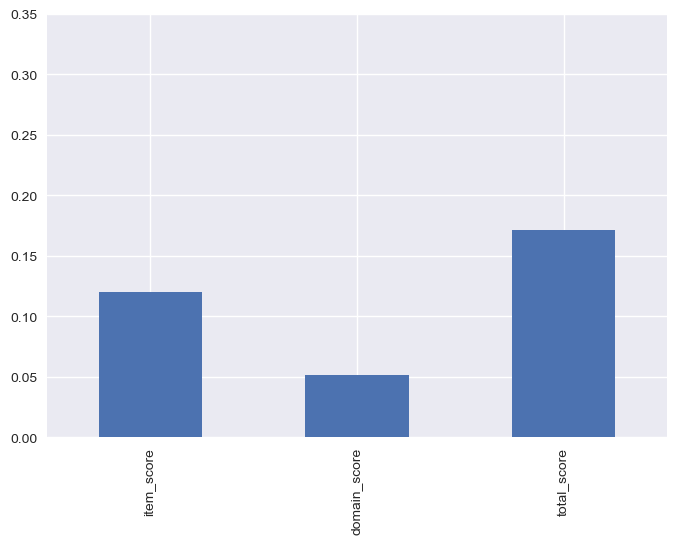

In [37]:
# Score baseline
score_baseline = GetScoreDesglosado(baseline, baseline_cat)
display(score_baseline)
score_baseline.plot.bar()
plt.ylim(0, 0.35)
plt.show()

#### EDA

c:\Users\leo_a\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


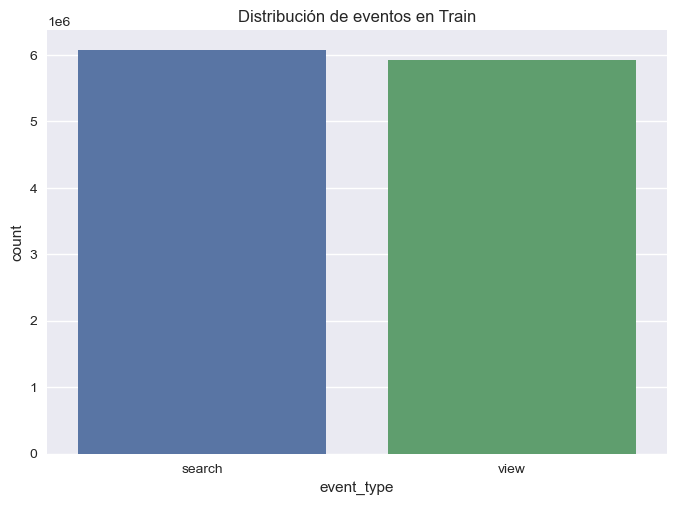

c:\Users\leo_a\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribución de eventos en Test')

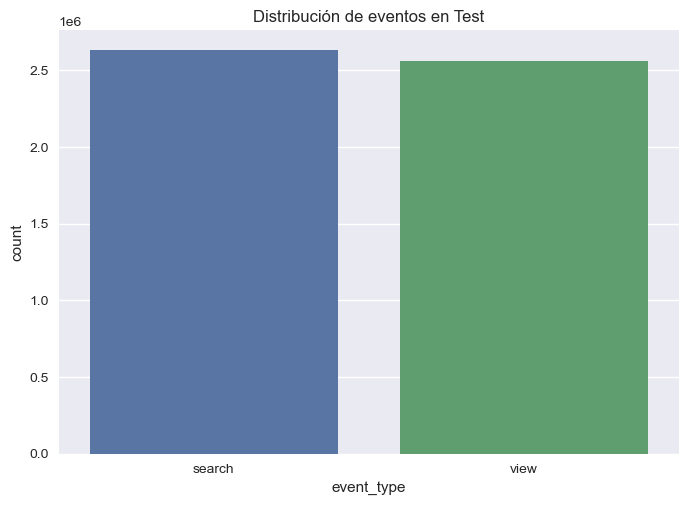

In [39]:
# Cuántas son searches y cuántas son views en cada dataset
train_events_extra_df.event_type.pipe(sns.countplot)
plt.title('Distribución de eventos en Train')
plt.show()
test_events_extra_df.event_type.pipe(sns.countplot)
plt.title('Distribución de eventos en Test')

<AxesSubplot:title={'center':'Precisión en Categoría, por posición'}>

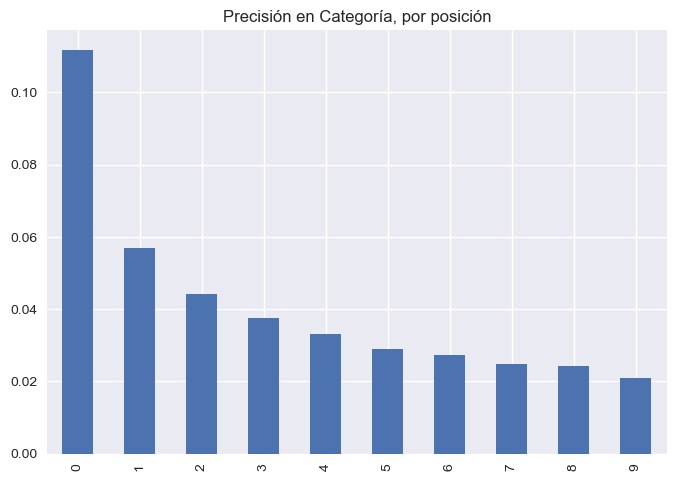

In [40]:
# Qué porcentaje de las veces la categoría correcta está en esa posición.
nan_pct = baseline.isna().mean()
((baseline == ytrue_matrix).mean()/(1-nan_pct)).plot.bar(title='Precisión en Categoría, por posición')

<AxesSubplot:title={'center':'Precisión en Categoría, por posición, descontando faltantes'}>

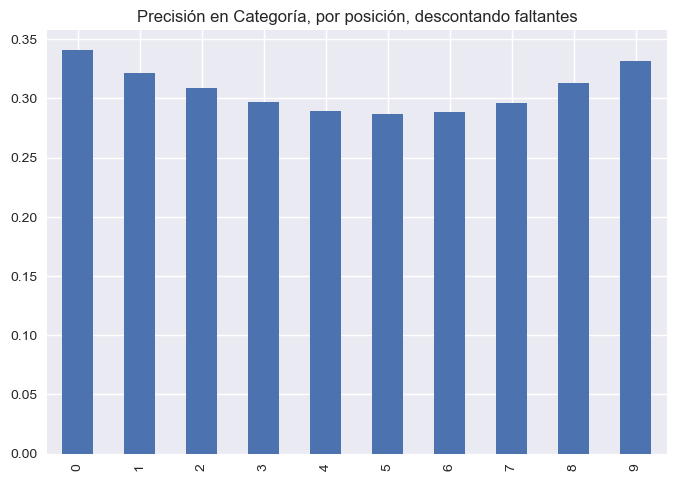

In [41]:
# Qué porcentaje de las veces la categoría correcta está en esa posición, compensando por nans.
((baseline_cat == ytrue_cat_matrix).mean(skipna=False)/(1-nan_pct)).plot.bar(title='Precisión en Categoría, por posición, descontando faltantes')

### Modelo predicción de categoría

#### NN

In [42]:
import itertools
from collections import defaultdict
import copy
import numpy as np

class MultiLabelCounter():
    def __init__(self, classes=None):
        self.classes_ = classes

    def fit(self,y):
        self.classes_ = sorted(set(itertools.chain.from_iterable(y)))
        self.mapping = dict(zip(self.classes_,
                                         range(len(self.classes_))))
        return self

    def transform(self,y):
        yt = []
        for labels in y:
            data = [0]*len(self.classes_)
            for label in labels:
                data[self.mapping[label]] +=1
            yt.append(data)
        return yt

    def fit_transform(self,y):
        return self.fit(y).transform(y)

import numpy as np
import itertools
from scipy.sparse import lil_matrix

class SparseMultiLabelCounter():
    def __init__(self, classes=None):
        self.classes_ = classes

    def fit(self, y):
        if self.classes_ is None:
            self.classes_ = sorted(set(itertools.chain.from_iterable(y)))
        self.mapping = dict(zip(self.classes_, range(len(self.classes_))))
        return self

    def transform(self, y):
        num_samples = len(y)
        num_classes = len(self.classes_)
        yt = lil_matrix((num_samples, num_classes), dtype=np.int32)

        for sample_idx, labels in enumerate(y):
            for label in labels:
                if label in self.mapping:
                    label_idx = self.mapping[label]
                    yt[sample_idx, label_idx] += 1

        return yt

    def fit_transform(self, y):
        return self.fit(y).transform(y)

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
encoder_x = MultiLabelBinarizer(classes=domain_uni_category.categories.values, sparse_output=True)
x = encoder_x.fit_transform(train_events_extra_df.groupby('session_id').domain_id_uni.apply(list))

encoder_y = OneHotEncoder(categories=[domain_uni_category.categories])
y = encoder_y.fit_transform(ytrue_cat.astype(str).str[4:].values.reshape(-1, 1))

from sklearn.model_selection import train_test_split
idx = train_events_extra_df.session_id.unique()
iloc_slice = np.arange(0, len(idx))
x_train, x_test, y_train, y_test, idx_train, idx_test, iloc_slice_train, iloc_slice_test = train_test_split(x, y, idx, iloc_slice, random_state=37,
                                                                                                            train_size=100000)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

c:\Users\leo_a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) [nan] will be ignored
  warnings.warn(


(100000, 4329) (313163, 4329) (100000, 4329) (313163, 4329)


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

def TrainTorch(xtrain, ytrain):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    input_shape = xtrain.shape[1]
    output_shape = ytrain.shape[1]

    model = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 1024),
            nn.ReLU(),

            nn.Linear(1024, output_shape)
            )
    
    if torch.cuda.is_available() and True:
        print('CUDA is available.')
        xtrain = xtrain.cuda()
        ytrain = ytrain.cuda()
        model  = model.cuda()
    
    from torch.utils.data import DataLoader, Dataset, TensorDataset
    dataset = TensorDataset(xtrain, ytrain)
    dataset_train, dataset_val = torch.utils.data.random_split(dataset, [0.9, 0.1])
    
    lr = 2*10**(-3)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=10**-4)

    class FocalLoss(nn.Module):
        def __init__(self, gamma=2, alpha=1, reduction='mean'):
            super(FocalLoss, self).__init__()
            self.gamma = gamma
            self.alpha = alpha
            self.reduction = reduction

        def forward(self, inputs, targets):
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Calculate the cross-entropy loss

            pt = torch.exp(-ce_loss)  # Calculate the predicted probabilities
            focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # Calculate the focal loss

            if self.reduction == 'mean':
                return focal_loss.mean()
            elif self.reduction == 'sum':
                return focal_loss.sum()
            else:
                return focal_loss

    # Instantiate the FocalLoss class with default gamma (2) and optional alpha
    criterion = FocalLoss(gamma=2, alpha=1)
    # criterion = nn.CrossEntropyLoss()

    batch_size = 64
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    max_epochs = 100
    
    dataloader_train = DataLoader(dataset    , batch_size=batch_size, shuffle=True)
    dataloader_val   = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
    
    patience_counter = 0
    patience = 3
    best_model = None
    min_val_loss = np.inf

    for epoch in tqdm(range(max_epochs)):
        
        train_loss = 0.0
        model.train()
        for i, (x, y) in enumerate(dataloader_train):
            preds = model(x.to_dense())

            # Compute the loss and printing ever 10 iterations
            loss = criterion(preds, y.to_dense())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        val_loss = 0.0
        model.eval()
        for x, y in dataloader_val:
            
            # Forward Pass
            preds = model(x)
            
            # Find the Loss
            loss = criterion(preds, y.to_dense())
            
            # Calculate Loss
            val_loss += loss.item()
            
        print('Training loss:', train_loss/n_batches_train, 'Validation loss:', val_loss/n_batches_val)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict()
        else:
            patience_counter += 1
            print(f'Patience counter: {patience_counter}')
            if patience_counter >= patience:
                print("Early stopping: Patience limit reached.")
                break

    if best_model is not None:
        model.load_state_dict(best_model)
    torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def scipy_csr_to_torch_csr(my_csr_matrix):
    from scipy.sparse import csr_matrix
    crow_indices = my_csr_matrix.indptr
    col_indices = my_csr_matrix.indices
    values = my_csr_matrix.data
    size = my_csr_matrix.shape
    
    return torch.sparse_csr_tensor(torch.IntTensor(crow_indices), 
                                   torch.IntTensor(col_indices),
                                   torch.FloatTensor(values), 
                                   size=size)

model_torch = TrainTorch(scipy_csr_to_torch_csr(x_train), scipy_csr_to_torch_csr(y_train))

C:\Users\leo_a\AppData\Local\Temp\ipykernel_17156\677611396.py:130: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:56.)
  return torch.sparse_csr_tensor(torch.IntTensor(crow_indices),


CUDA is available.


  0%|          | 0/100 [00:00<?, ?it/s]

Training loss: 5.454106000440715 Validation loss: 3.817664580739987
Training loss: 4.218584766265934 Validation loss: 2.8852108253794873
Training loss: 3.27417042489245 Validation loss: 2.1004274073679734
Training loss: 2.4619876365756515 Validation loss: 1.5224719670168154
Training loss: 1.854427889804935 Validation loss: 1.1866830606369456
Training loss: 1.4958553876788716 Validation loss: 1.022613731159526
Training loss: 1.3079083007154688 Validation loss: 0.9245286547833946
Training loss: 1.1959387956567071 Validation loss: 0.874343946860854
Training loss: 1.1266612978632262 Validation loss: 0.817958479853952
Training loss: 1.07858134832633 Validation loss: 0.8107362406648648
Training loss: 1.041167033506609 Validation loss: 0.7724833739980771
Training loss: 1.016338888113602 Validation loss: 0.7658495202565648
Training loss: 0.9968422034698424 Validation loss: 0.7603666471068267
Training loss: 0.9757960306555986 Validation loss: 0.739681954406629
Training loss: 0.9637844067096032 

In [45]:
# Visualizar predicciones
y_preds_10 = model_torch(scipy_csr_to_torch_csr(x_test).to('cuda')).topk(10).indices.detach().cpu().numpy()

print(y_preds_10)

[[1198  467  393 ...  395   24   28]
 [  91 1286  168 ...   47   37  761]
 [ 200   28   43 ...   39   89   36]
 ...
 [ 223    6  440 ...  732  311  417]
 [ 202  319  274 ...  887  483  223]
 [1198  313  244 ...  202  312 2566]]


0    0.230014
1    0.062255
2    0.033082
3    0.023199
4    0.017924
5    0.014759
6    0.012814
7    0.011029
8    0.010075
9    0.008829
Name: 0, dtype: float64

<AxesSubplot:title={'center':'Precisión en Categoría, por posición'}>

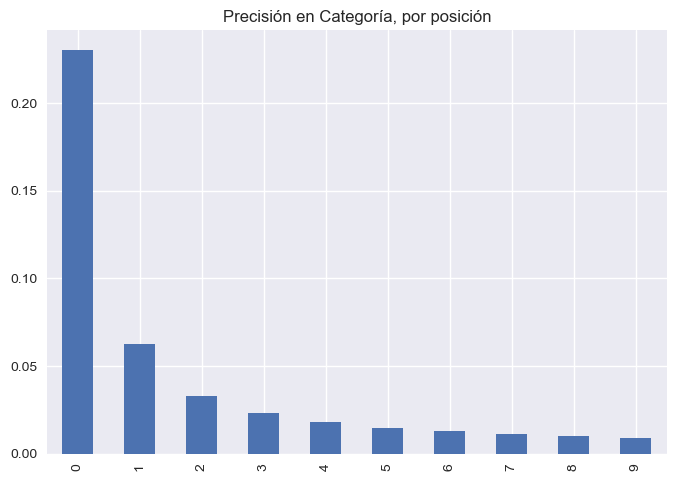

In [46]:
# Performance
display(pd.DataFrame((y_preds_10 == np.hstack([y_test.argmax(1)]*10)).mean(0)).loc[0])
pd.DataFrame((y_preds_10 == np.hstack([y_test.argmax(1)]*10)).mean(0)).loc[0].plot.bar(title='Precisión en Categoría, por posición')

In [47]:
pd.Categorical.from_codes(y_test.argmax(1), domain_category.categories)
pd.Categorical.from_codes(y_preds_10, domain_category.categories)

[['MLM-HARD_DRIVE_AND_SSD_ENCLOSURES', 'MLM-INK..., ['MLM-PANTS', 'MLM-SHORTS', 'MLM-T_SHIRTS', 'M..., ['MLM-PRINTER_INKS', 'MLM-HEADPHONES', 'MLM-BI..., ['MLM-MAKEUP_BRUSHES', 'MLM-PERFUMES', 'MLM-PO..., ['MLM-BLOUSES', 'MLM-SHORTS', 'MLM-T_SHIRTS', ..., ..., ['MLM-GARDEN_HOSES', 'MLM-POWER_STRIPS', 'MLM-..., ['MLM-SPEAKER_GRILLS', 'MLM-PANTIES', 'MLM-HAC..., ['MLM-HAIR_STRAIGHTENERS', 'MLM-CELLPHONE_COVE..., ['MLM-SUPPLEMENTS', 'MLM-NAIL_POLISH', 'MLM-GA..., ['MLM-HARD_DRIVE_AND_SSD_ENCLOSURES', 'MLM-PRI...]
Length: 313163
Categories (7893, object): ['MLM-INDIVIDUAL_HOUSES_FOR_SALE', 'MLM-VIDEO_GAMES', 'MLM-SKIRTS', 'MLM-GRAPHICS_CARDS', ..., 'MLB-GLASS_SAFETY_FILMS', 'MLB-SCREEN_PRINTING_KITS', 'MLB-ANTIQUE_AUDIO_ANTENNAS', 'MLB-RUGBY_HELMETS']

In [48]:
GetCatScore(y_preds_10, y_test.argmax(1))

0.020674287788042974

#### ALS

In [49]:
# Decomposición ALS
from sklearn.decomposition import NMF
decomposer = NMF(n_components=100)
decomposer.fit(x_train)

NMF(n_components=100)

In [50]:
W = decomposer.transform(x_test)
H = decomposer.components_

In [51]:
W = np.float16(W)
H = np.float16(H)
preds_ALS = np.dot(W, H)

In [52]:
# Sparse ALS predictions que sale de W*H
from scipy import sparse
sparse_ALS = sparse.csr_matrix(np.where(preds_ALS < 0.001, 0, preds_ALS))

In [53]:
# Cuáles y cuántas son todo 0
idx_no_pred = (pd.DataFrame.sparse.from_spmatrix(sparse_ALS) == 0).all(1).replace(False, np.nan).dropna().sort_index().index

print(len(idx_no_pred))

349


In [54]:
# Agarrar categoría más predicha para cada sesión
preds_cat_ALS = pd.DataFrame.sparse.from_spmatrix(sparse_ALS).progress_apply(lambda x:x.argmax(), axis=1).map(domain_uni_mapdict)
# Donde no hay predicción, predigo celulares
preds_cat_ALS.loc[idx_no_pred] = 'CELLPHONES'
preds_cat_ALS = pd.Series(preds_cat_ALS.values, index=idx_test)
# SavePickle(preds_cat_ALS, 'preds_cat_ALS')

# preds_cat_ALS = LoadPickle('preds_cat_ALS')

  0%|          | 0/313163 [00:00<?, ?it/s]

#### Different algorithm scores

In [55]:
def CatAccuracy(truth, preds):
    # truth = train_target_extra.loc[idx_test, 'domain_id']
    # preds = preds_cat_nn_10
    list_accuracy = pd.Series([np.round((truth == preds.iloc[:, i]).mean(), 4) for i in range(10)])
    total_accuracy = list_accuracy.sum()
    weighted_accuracy = (list_accuracy*multipliers).sum()
    print(list_accuracy, total_accuracy, weighted_accuracy)
    
    return

In [56]:
(baseline_cat.loc[idx_test, :].fillna('MLB-CELLPHONES').applymap(lambda x:x[4:]).apply(lambda x:x.astype(domain_uni_category).cat.codes).values == \
    np.hstack([y_test.argmax(1)]*10)).mean(0)

matrix([[0.32135022, 0.25695564, 0.21663159, 0.1861331 , 0.16269802,
         0.14260625, 0.12436654, 0.10829823, 0.09277597, 0.07838729]])

In [57]:
# NN accuracy
pd.DataFrame((y_preds_10 == np.hstack([y_test.argmax(1)]*10)).mean(0)).T[0]

0    0.230014
1    0.062255
2    0.033082
3    0.023199
4    0.017924
5    0.014759
6    0.012814
7    0.011029
8    0.010075
9    0.008829
Name: 0, dtype: float64

In [60]:
pd.Series(preds_cat_ALS.values).astype(domain_uni_category).cat.codes.values.reshape(-1, 1)

array([ 312,   91,   43, ...,  105, 1629,  259], dtype=int16)

In [61]:
# ALS accuracy
(pd.Series(preds_cat_ALS.values).astype(domain_uni_category).cat.codes.values.reshape(-1, 1) == y_test.argmax(1)).mean()

0.18985001420985237

In [62]:
# Match entre NN y ALS
(pd.Series(preds_cat_ALS.values).astype(domain_uni_category).cat.codes.values == y_preds_10[:, 0]).mean()

0.275208118455884

## Lleno NaNs de la baseline con predicciones de modelo anterior

In [63]:
def FillPreds(preds_with_nans, preds_cat_series, type_ = 'a'):
    """Dada una serie de categorías predichas, obtiene los items más vendidos para esa categoría para rellenar las predicciones. Si el tipo es 'a', solo rellena los nans,
    si el tipo es 'b', entonces solo mantenemos una predicción con los items visto, y llenamos 9 con las categorías del modelo"""
    preds = preds_with_nans.copy()
    # Agarro los items más vendidos de cada categoría para fila una fila de domains predichos
    most_sold_items_by_category_for_preds = most_sold_items_by_category\
                                            .loc[preds_cat_series].values
    
    # Según type a o b, concatenar predicciones con top items
    if type_ == 'a':
        print('Concatenating predictions with top items for domain predicted')
        for i, (row_name, row) in enumerate(tqdm(preds.iterrows(),
                                                 total=len(preds))):
            preds.iloc[i] = np.concatenate([row.dropna().values,
                                            most_sold_items_by_category_for_preds[i]])[:10]
    elif type_ == 'b':
        preds.iloc[:, 1:] = most_sold_items_by_category_for_preds[:, :-1] 
    else:
        raise Exception('type_ should be a or b')

    preds[:] = np.where(preds.isna(), most_sold_items_by_mercado.Top_MLB, preds)
        
    return preds

In [64]:
def CategoryNNPreds(events_extra_df, preds, idx_= None):
    slice_ = slice(None) if idx_ is None else idx_
    resultado = []
    mercado_first = events_extra_df.groupby('session_id').mercado.first().loc[slice_].astype(str)
    for codigo in mercado_first + '-' + pd.Categorical.from_codes(preds[:, 0], categories=domain_uni_category.categories).astype(str):
        if codigo in most_sold_items_by_category.index:
            resultado.append(codigo)
        else:
            resultado.append('MLB-CELLPHONES')
    return pd.Series(resultado).astype(domain_category)

y_preds_cat = CategoryNNPreds(train_events_extra_df, y_preds_10, idx_=idx_test)

In [65]:
preds_a_base = FillPreds(baseline, baseline_cat.iloc[:, 0].fillna('MLB-CELLPHONES'), 'a')
preds_b_base = FillPreds(baseline, baseline_cat.iloc[:, 0].fillna('MLB-CELLPHONES'), 'b')
preds_a_tf = FillPreds(baseline.loc[idx_test], y_preds_cat, 'a')
preds_b_tf = FillPreds(baseline.loc[idx_test], y_preds_cat, 'b')

Concatenating predictions with top items for domain predicted


  0%|          | 0/413163 [00:00<?, ?it/s]

Concatenating predictions with top items for domain predicted


  0%|          | 0/313163 [00:00<?, ?it/s]

In [66]:
display(preds_a_base.head(2), preds_b_base.head(2), preds_a_tf.head(2), preds_b_tf.head(2))

,0,1,2,3,4,5,6,7,8,9
0,1615991.0,1786148.0,1361154.0,725371.0,1748830.0,849156.0,1127740.0,87559.0,817689.0,1839144.0
1,228737.0,1282813.0,206667.0,1943604.0,1156086.0,643652.0,1230986.0,1341158.0,864577.0,1609425.0


,0,1,2,3,4,5,6,7,8,9
0,1615991.0,1361154.0,725371.0,1748830.0,849156.0,1127740.0,87559.0,817689.0,1839144.0,1154325.0
1,228737.0,1230986.0,1341158.0,864577.0,1609425.0,855886.0,378092.0,868817.0,99212.0,1020061.0


,0,1,2,3,4,5,6,7,8,9
209696,957635.0,1760621.0,503000.0,503281.0,1845384.0,1644912.0,2004970.0,564597.0,1586796.0,1055074.0
325971,990570.0,1368273.0,1813846.0,1628496.0,1197718.0,459433.0,1267666.0,1251724.0,715914.0,610559.0


,0,1,2,3,4,5,6,7,8,9
209696,957635.0,2004970.0,564597.0,1586796.0,1055074.0,738243.0,1027451.0,1180648.0,64625.0,830483.0
325971,990570.0,1628496.0,1197718.0,459433.0,1267666.0,1251724.0,715914.0,610559.0,398330.0,115759.0


In [67]:
GetScoreDesglosado(preds_a_base.loc[idx_test], idx=iloc_slice_test)

Predicción de categorías no proporcionada.
Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
209696,MLM-COMPUTER_MICE,MLM-CELLPHONES,MLM-CELLPHONES,MLM-CELLPHONES,MLM-PC_KEYBOARDS,MLM-PC_KEYBOARDS,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE
325971,MLB-PANTS,MLB-DISPOSABLE_CUPS,MLB-CAR_CARBURETORS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS


item_score      0.145473
domain_score    0.090669
total_score     0.236142
dtype: float64

In [68]:
GetScoreDesglosado(preds_b_base.loc[idx_test], idx=iloc_slice_test)

Predicción de categorías no proporcionada.
Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
209696,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE,MLM-COMPUTER_MICE
325971,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS


item_score      0.115685
domain_score    0.092964
total_score     0.208649
dtype: float64

In [69]:
GetScoreDesglosado(preds_a_tf.loc[idx_test], idx=iloc_slice_test)

Predicción de categorías no proporcionada.
Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
209696,MLM-COMPUTER_MICE,MLM-CELLPHONES,MLM-CELLPHONES,MLM-CELLPHONES,MLM-PC_KEYBOARDS,MLM-PC_KEYBOARDS,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES
325971,MLB-PANTS,MLB-DISPOSABLE_CUPS,MLB-CAR_CARBURETORS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS


item_score      0.136527
domain_score    0.082789
total_score     0.219317
dtype: float64

In [70]:
GetScoreDesglosado(preds_b_tf.loc[idx_test], idx=iloc_slice_test)

Predicción de categorías no proporcionada.
Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
209696,MLM-COMPUTER_MICE,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES
325971,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS


item_score      0.098585
domain_score    0.072784
total_score     0.171370
dtype: float64

### Reorder baseline based on predictions

In [71]:
def Model_Reorder(base_preds_full, base_preds_full_category, category_preds):
    "Recibe df con predicciones baseline, un df con la categoría de las predicciones baseline, y una series con predicciones de categoría de un modelo para cada sesión."

    if type(category_preds) != pd.Series:
        category_preds = pd.Series(category_preds)

    # Reset index of all dfs
    base_preds_full = base_preds_full.reset_index(drop=True).copy()
    base_preds_full_category = base_preds_full_category.reset_index(drop=True).copy()
    category_preds = category_preds.reset_index(drop=True).copy()
    
    # Create function to reorder rows based on category predictions
    def ReorderPreds(series_of_preds):
        # Get positions where viewed item matches predicted category, by using categories of predictions dataframe, and predicted categories series.
        i = series_of_preds.name
        idx_where_cat_true = (base_preds_full_category.iloc[i] == category_preds.iloc[i])\
                             .values.nonzero()
        # Get values where idx matches, and concatenate to where it doesn't match
        return pd.Series(np.concatenate([series_of_preds.values[idx_where_cat_true],
                        np.delete(series_of_preds.values, idx_where_cat_true)]))

    # Run function on each row
    print('Reordenando filas...')
    return base_preds_full.progress_apply(lambda x:ReorderPreds(x), axis=1).iloc[:, :10]

In [72]:
baseline_full = Model_1(train_events_extra_df)
baseline_full = baseline_full.apply(limpiar_predicciones_baseline, axis=1)
baseline_full_cat = GetPredsCat(baseline_full)

Agarrando las últimas 10 categorías vistas...


  0%|          | 0/413163 [00:00<?, ?it/s]

Converting to DataFrame


,0,1,2,3,4,5,6,7,8,9
0,1615991,RELOGIO SMARTWATCH,1786148,None,None,None,None,None,None,None
1,228737,1282813,206667,1943604,1156086,DESMAMADEIRA ELETRICA,643652,None,None,None


C:\Users\leo_a\AppData\Local\Temp\ipykernel_17156\1478659843.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(new_row)


Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,MLB-SMARTWATCHES,MLB-SMARTWATCHES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-MILK_EXTRACTORS,MLB-SHOWER_HEADS,NaN,NaN,NaN,NaN


In [74]:
baseline_test_reordered = Model_Reorder(baseline_full.loc[idx_test], baseline_full_cat.loc[idx_test], y_preds_cat)
baseline_test_reordered

Reordenando filas...


  0%|          | 0/313163 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,957635.0,1760621.0,503000.0,503281.0,1845384.0,1644912.0,NaN,NaN,NaN,NaN
1,990570.0,1368273.0,1813846.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,877640.0,2022804.0,1605635.0,1533647.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1443889.0,919165.0,343186.0,1413572.0,1268400.0,2066520.0,71917.0,1551403.0,1014572.0,NaN
4,991308.0,6465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
313158,1845118.0,1121418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313159,259488.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313161,865881.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
baseline_test_reordered_filled = FillPreds(baseline_test_reordered, y_preds_cat)
baseline_test_reordered_filled

Concatenating predictions with top items for domain predicted


  0%|          | 0/313163 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,957635.0,1760621.0,503000.0,503281.0,1845384.0,1644912.0,2004970.0,564597.0,1586796.0,1055074.0
1,990570.0,1368273.0,1813846.0,1628496.0,1197718.0,459433.0,1267666.0,1251724.0,715914.0,610559.0
2,877640.0,2022804.0,1605635.0,1533647.0,1691453.0,1589320.0,543860.0,1039058.0,445289.0,394965.0
3,1443889.0,919165.0,343186.0,1413572.0,1268400.0,2066520.0,71917.0,1551403.0,1014572.0,1593939.0
4,991308.0,6465.0,1386453.0,1382821.0,1773543.0,1345850.0,189137.0,1201327.0,1856109.0,2052529.0
...,...,...,...,...,...,...,...,...,...,...
313158,1845118.0,1121418.0,772852.0,1820707.0,1470284.0,767066.0,705631.0,149032.0,1819528.0,634777.0
313159,259488.0,1216975.0,1617569.0,557007.0,104903.0,1286023.0,218582.0,1847905.0,859574.0,290755.0
313160,361054.0,522274.0,702690.0,1147275.0,924344.0,465880.0,666252.0,2061557.0,1935154.0,1020313.0
313161,865881.0,899713.0,830693.0,1842210.0,1027487.0,1096404.0,287295.0,965457.0,1498256.0,1781894.0


In [77]:
GetScoreDesglosado(baseline_test_reordered_filled, idx=iloc_slice_test)

Predicción de categorías no proporcionada.
Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,MLM-COMPUTER_MICE,MLM-CELLPHONES,MLM-CELLPHONES,MLM-CELLPHONES,MLM-PC_KEYBOARDS,MLM-PC_KEYBOARDS,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES,MLM-HARD_DRIVE_AND_SSD_ENCLOSURES
1,MLB-PANTS,MLB-DISPOSABLE_CUPS,MLB-CAR_CARBURETORS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS,MLB-PANTS


item_score      0.136916
domain_score    0.083325
total_score     0.220242
dtype: float64

## Predecimos dataset para submission y exportamos en .csv

In [78]:
test_baseline_full = Model_1(test_events_extra_df).apply(limpiar_predicciones_baseline, axis=1)

Agarrando las últimas 10 categorías vistas...


  0%|          | 0/177070 [00:00<?, ?it/s]

Converting to DataFrame


,0,1,2,3,4,5,6,7,8,9
0,685656,RECEPTOR CINE BOX EXTREME 4K,RECEPTOR CINE BOX 4K FANTASIA,RECEPTOR CINE BOX 4K,CINE BOX 4K,1194894,1572239,None,None,None
1,849692,CONJUNTO ESCAMA PEIXE 45 MM,26324,788705,48097,943786,1125393,831243,PENTE SOLTO PRA MAQUINA BRITANIA N1,PENTE PRA MAQUINA BRITANIA


C:\Users\leo_a\AppData\Local\Temp\ipykernel_17156\1478659843.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(new_row)


In [79]:
test_baseline_full_categories = GetPredsCat(test_baseline_full)

Getting categories from item predictions...


  0%|          | 0/10 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,MLB-STREAMING_MEDIA_DEVICES,MLB-PANTS,MLB-HARD_DRIVES_AND_SSDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLB-NECKLACES,MLB-HAIR_CLIPPERS,MLB-HAIR_CLIPPERS,MLB-HAIR_CLIPPERS,MLB-HAIR_CLIPPERS,MLB-HAIRDRESSING_SCISSORS,MLB-HAIR_CLIPPERS,NaN,NaN,NaN


In [80]:
x_sub = encoder_x.transform(test_events_extra_df.groupby('session_id').domain_id_uni.apply(list))

y__preds_10_sub = model_torch(scipy_csr_to_torch_csr(x_sub).to('cuda')).topk(10).indices.detach().cpu().numpy()
y__preds_10_sub

c:\Users\leo_a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) [nan] will be ignored
  warnings.warn(


array([[  40,   91,   46, ...,   16,  168, 1014],
       [ 440, 2988, 1210, ...,  761, 1958,  314],
       [  19, 2541,  603, ...,  537,  840, 1144],
       ...,
       [  19,  233,   16, ...,  200,  107,   14],
       [  47,   31,  729, ...,  101,  945,   44],
       [1698, 2873,  388, ...,  394,  967,  478]], dtype=int64)

In [81]:
y_preds_cat_sub = CategoryNNPreds(test_events_extra_df, y__preds_10_sub, idx_=None)
y_preds_cat_sub.head()

0     MLB-SMARTWATCHES
1    MLB-HAIR_CLIPPERS
2     MLM-WRISTWATCHES
3       MLB-CELLPHONES
4         MLB-EARRINGS
dtype: category
Categories (7893, object): ['MLM-INDIVIDUAL_HOUSES_FOR_SALE', 'MLM-VIDEO_GAMES', 'MLM-SKIRTS', 'MLM-GRAPHICS_CARDS', ..., 'MLB-GLASS_SAFETY_FILMS', 'MLB-SCREEN_PRINTING_KITS', 'MLB-ANTIQUE_AUDIO_ANTENNAS', 'MLB-RUGBY_HELMETS']

In [82]:
test_baseline_full_reordered = Model_Reorder(test_baseline_full, test_baseline_full_categories, y_preds_cat_sub)
test_baseline_full_reordered.head()

Reordenando filas...


  0%|          | 0/177070 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,685656.0,1194894.0,1572239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26324.0,788705.0,48097.0,943786.0,831243.0,849692.0,1125393.0,NaN,NaN,NaN
2,1614538.0,1219935.0,539599.0,167018.0,1362449.0,1425647.0,283306.0,1660615.0,991246.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
test_baseline_full_reordered_filled = FillPreds(test_baseline_full_reordered, y_preds_cat_sub)
test_baseline_full_reordered_filled.head()

Concatenating predictions with top items for domain predicted


  0%|          | 0/177070 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9
0,685656.0,1194894.0,1572239.0,1361154.0,725371.0,1748830.0,849156.0,1127740.0,87559.0,817689.0
1,26324.0,788705.0,48097.0,943786.0,831243.0,849692.0,1125393.0,361733.0,1140688.0,1056120.0
2,1614538.0,1219935.0,539599.0,167018.0,1362449.0,1425647.0,283306.0,1660615.0,991246.0,574874.0
3,859574.0,1371799.0,119703.0,1332849.0,882697.0,1098739.0,98853.0,790888.0,967194.0,1595373.0
4,308910.0,1939602.0,1730320.0,1629732.0,1301735.0,1642811.0,726439.0,1159663.0,805864.0,1945218.0


In [84]:
preds_test = test_baseline_full_reordered_filled.astype(int)
preds_test.head()

,0,1,2,3,4,5,6,7,8,9
0,685656,1194894,1572239,1361154,725371,1748830,849156,1127740,87559,817689
1,26324,788705,48097,943786,831243,849692,1125393,361733,1140688,1056120
2,1614538,1219935,539599,167018,1362449,1425647,283306,1660615,991246,574874
3,859574,1371799,119703,1332849,882697,1098739,98853,790888,967194,1595373
4,308910,1939602,1730320,1629732,1301735,1642811,726439,1159663,805864,1945218


In [85]:
preds_test = preds_test.fillna(method='pad').astype(int)
preds_test.head()

,0,1,2,3,4,5,6,7,8,9
0,685656,1194894,1572239,1361154,725371,1748830,849156,1127740,87559,817689
1,26324,788705,48097,943786,831243,849692,1125393,361733,1140688,1056120
2,1614538,1219935,539599,167018,1362449,1425647,283306,1660615,991246,574874
3,859574,1371799,119703,1332849,882697,1098739,98853,790888,967194,1595373
4,308910,1939602,1730320,1629732,1301735,1642811,726439,1159663,805864,1945218


In [87]:
preds_test.to_csv('sub_final.csv', header=False, index=False)